# Oil Wells Prediction Machine Learning

Project Report by Allentine Paulis

# Table of Contents
* [Project Description](#description)
* [Data](#data)
* [Step 1. Understanding Data and Data Preprocessing](#understanding)
* [Step 2. Train and Test Machine Learning Model](#traintest)   
* [Step 3. Profit Calculation](#profitcalculation)
* [Step 4. Bootstrap Profit and Risk Calculation for Each Region](#riskcalculation)
* [Step 5. Overall conclusion](#allconclusion)

# Project Description <a class="anchor" id="description"></a>

For the OilyGiant mining company, the task is to find the best place for a new well.


Steps to choose the location:
- Collect the oil well parameters in the selected region: oil quality and volume of reserves;
- Build a model for predicting the volume of reserves in the new wells;
- Pick the oil wells with the highest estimated values;
- Pick the region with the highest total profit for the selected oil wells.


We have data on oil samples from three regions. Parameters of each oil well in the region are already known. We are going to build a model that will help to pick the region with the highest profit margin. Analyze potential profit and risks using the Bootstrapping technique.

# Data <a class="anchor" id="data"></a>
Geological exploration data for the three regions are stored in files:
- geo_data_0.csv. https://code.s3.yandex.net/datasets/geo_data_0.csv
- geo_data_1.csv. https://code.s3.yandex.net/datasets/geo_data_1.csv
- geo_data_2.csv. https://code.s3.yandex.net/datasets/geo_data_2.csv
- id — unique oil well identifier
- f0, f1, f2 — three features of points (their specific meaning is unimportant, but the features themselves are significant)
- product — volume of reserves in the oil well (thousand barrels).

**Conditions**:
- Only linear regression is suitable for model training (the rest are not sufficiently predictable).
- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
- The budget for development of 200 oil wells is 100 USD million.
- One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).
- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

The data is synthetic: contract details and well characteristics are not disclosed.

# Step 1. Understanding Data and Data Preprocessing<a class="anchor" id="understanding"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats as st

state = np.random.RandomState(12345)

import scipy as sp
import scipy.stats

In [2]:
df0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv')
df1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv')
df2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv')

In [3]:
display(df0.head())
display(df1.head())
display(df2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
display(df0.info())
display(df1.info())
display(df2.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB


None

They have 5 columns and 100000 rows.

In [5]:
display(df0.describe())
display(df1.describe())
display(df2.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


In [6]:
display(df0.isna().sum())
display(df1.isna().sum())
display(df2.isna().sum())

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

No missing values

In [7]:
display(df0.duplicated().sum())
display(df1.duplicated().sum())
display(df2.duplicated().sum())

0

0

0

No duplicated value

In [8]:
display(df0.nunique())
display(df1.nunique())
display(df2.nunique())

id          99990
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product        12
dtype: int64

id          99996
f0         100000
f1         100000
f2         100000
product    100000
dtype: int64

There are 99996 unique ID in all dataframe.

There are 12 unique products in Geo Data 2.

In [9]:
display(df0.corr())
display(df1.corr())
display(df2.corr())

,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


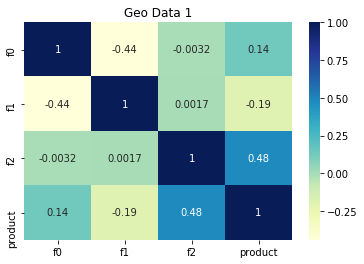

In [10]:
sns.heatmap(df0.corr(), annot=True, cmap="YlGnBu")
plt.title('Geo Data 1')
plt.show()

In Geo Data 1, F2 has strong positive correlation 0.48 with product.

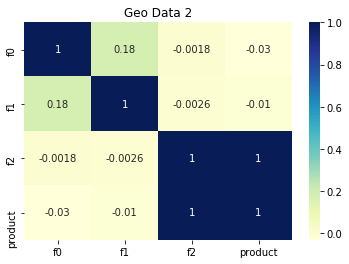

In [11]:
sns.heatmap(df1.corr(), annot=True, cmap="YlGnBu")
plt.title('Geo Data 2')
plt.show()

In Geo Data 2, F2 has strong positive correlation 1 with product.

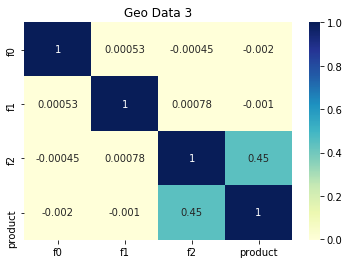

In [12]:
sns.heatmap(df2.corr(), annot=True, cmap="YlGnBu")
plt.title('Geo Data 3')
plt.show()

In Geo Data 3, F2 has strong positive correlation 0.45 with product.

## Conclusion

- There are 100000 rows and 5 columns.
- There are 99996 unique ID in all dataframe. So some ID might have duplicate values in ID column.
- There are 12 unique products in Geo Data 2.
- F2 has strong positive correlation with product.

# Step 2.  Train and Test Machine Learning Model  <a class="anchor" id="traintest"></a>

Train and test the model for each region:
- 2.1. Split the data into a training set and validation set at a ratio of 75:25.
- 2.2. Train the model and make predictions for the validation set.
- 2.3. Save the predictions and correct answers for the validation set.
- 2.4. Print the average volume of predicted reserves and model RMSE.
- 2.5. Analyze the results.

In [13]:
datasets = [df0, df1, df2]
features_train = []
features_valid = []
targets_train = []
targets_valid = []

for df in datasets:
    df = df.copy()
    X = df.drop(['product','id'], axis=1)
    y = df['product']
    X_train, X_valid, y_train, y_valid = train_test_split(X, y,test_size = 0.25, random_state=state)
    features_train.append(X_train)
    features_valid.append(X_valid)
    targets_train.append(y_train)
    targets_valid.append(y_valid)

In [14]:
from collections import defaultdict
d = defaultdict(list)
preds = []
for i in range(len(datasets)):
    model = LinearRegression()
    model.fit(features_train[i], targets_train[i])
    pred = model.predict(features_valid[i])
    preds.append(pred)
    d['region'].append(i+1)
    d['rmse'].append(mean_squared_error(targets_valid[i], pred) ** 0.5)
    d['score'].append(model.score(features_train[i], targets_train[i]))
    d['pred_mean'].append(pred.mean())
    d['target_mean'].append(targets_train[i].mean())
display(pd.DataFrame(d))

,region,rmse,score,pred_mean,target_mean
0,1,37.579422,0.274239,92.592568,92.640468
1,2,0.889737,0.999624,68.769951,68.842792
2,3,39.958042,0.197517,95.087528,95.083680


## Conclusion
- The prediction mean and target mean are similar.
- The model for region 1 and region 3 have poor result, we should not use them to select a well in the region.
- Lower values of RMSE indicate better fit.
- The model of the second region performed very well, but because the target (product) has only 12 values out of 100,000, it was easy for the model to predict the correct answer, but the second model is dangerous to use. 

# Step 3. Profit Calculation  <a class="anchor" id="profitcalculation"></a>

Prepare for profit calculation:
- 3.1. Store all key values for calculations in separate variables.
- 3.2. Calculate the volume of reserves sufficient for developing a new well without losses. Compare the obtained value with the average volume of reserves in each region.
- 3.3. Provide the findings about the preparation for profit calculation step.


Write a function to calculate profit from a set of selected oil wells and model predictions:
- 3.4. Pick the wells with the highest values of predictions.
- 3.5. Summarize the target volume of reserves in accordance with these predictions
- 3.6. Provide findings: suggest a region for oil wells' development and justify the choice. Calculate the profit for the obtained volume of reserves.

- When exploring the region, a study of 500 points is carried with picking the best 200 points for the profit calculation.
- The budget for development of 200 oil wells is 100 USD million.
- One barrel of raw materials brings 4.5 USD of revenue The revenue from one unit of product is 4,500 dollars (volume of reserves is in thousand barrels).

In [15]:
budget = 100000000 # 100 usd million
total_points = 500
best_wells = 200 
revenue_one_barrell = 4.5 # usd
revenue_one_product = 4500 # usd

In [16]:
# Calculate the price for drilling one well
well_price = budget / best_wells
well_price

500000.0

In [17]:
 # Calculate the volume of reserves sufficient for developing a new well without losses
vol_well = well_price/revenue_one_product
vol_well

111.11111111111111

The goal is at least 111 barrell without losses.

In [18]:
def profit(target, predictions, count):
    pred_sorted = pd.Series(predictions).reset_index(drop=True).sort_values(ascending=False)
    selected = target.reset_index(drop=True).iloc[pred_sorted.index][:count]
    
    product_vol = selected.sum()
    revenue = product_vol * revenue_one_product
    cost = count * well_price
    
    return (revenue - cost)

In [19]:
print('Profit for first region is {:.2f}'.format(profit(targets_valid[0], preds[0],200)))
print('Profit for second region is {:.2f}'.format(profit(targets_valid[1], preds[1],200)))
print('Profit for third region is {:.2f}'.format(profit(targets_valid[2], preds[2],200)))

Profit for first region is 33208260.43
Profit for second region is 24150866.97
Profit for third region is 25399159.46


## Conclusion
- The minimum volume of raw materials in each well should be 111 barrels.
- Our best profit is from region 0, but we will check this with bootstrap method

# Step 4. Bootstrap Profit and Risk Calculation for Each Region  <a class="anchor" id="riskcalculation"></a>

- 4.1. Use the bootstrapping technique with 1000 samples to find the distribution of profit.
- 4.2. Find average profit, 95% confidence interval and risk of losses. Loss is negative profit, calculate it as a probability and then express as a percentage.
- 4.3. Provide findings: suggest a region for development of oil wells and justify the choice.


- After the risk evaluation, keep only the regions with the risk of losses lower than 2.5%. From the ones that fit the criteria, the region with the highest average profit should be selected.

In [20]:
state = np.random.RandomState(12345)
def bootstrap_profit(target_bootstrap, prediction_bootstrap):
    profits = []
    for i in range(1000):
        target_subsample = target_bootstrap.reset_index(drop=True).sample(n=500, replace=True, random_state=state)
        pred_subsample = pd.Series(prediction_bootstrap).iloc[target_subsample.index]
        profits.append(profit(target_subsample, pred_subsample, 200))
    profits = pd.Series(profits)
    
    # calculate mean, confidence interval limits and risk of losses
    average = np.round(profits.mean(),2)
    lower = np.round(profits.quantile(0.025),2)
    upper = np.round(profits.quantile(0.975),2)
    confidence_interval = (lower, upper)
    risks = np.round(((profits < 0).sum() / len(profits)) * 100,2)
    
    print("Average profit:",average)
    print("25% Quantile:", lower)
    print('95% Confidence Interval:', confidence_interval)
    print("Risk:", risks, '%')
    
    return average, lower, confidence_interval,risks

In [21]:
d = defaultdict(list)
for region in range(len(datasets)):
    print("Region", region+1)
    average, lower, confidence_interval,risks = bootstrap_profit(targets_valid[region], preds[region])
    
    d['region'].append(region +1)
    d['average_profits'].append(average)
    d['2.5%_quantile'].append(lower)
    d['95%_confidence_interval'].append(confidence_interval)
    d['risks_%'].append(risks)
    print()

Region 1
Average profit: 3961649.85
25% Quantile: -1112155.46
95% Confidence Interval: (-1112155.46, 9097669.42)
Risk: 6.9 %

Region 2
Average profit: 4428504.06
25% Quantile: 558019.3
95% Confidence Interval: (558019.3, 8310233.31)
Risk: 1.6 %

Region 3
Average profit: 3447634.88
25% Quantile: -1975473.58
95% Confidence Interval: (-1975473.58, 8360618.52)
Risk: 10.8 %



In [22]:
display(pd.DataFrame(d))

,region,average_profits,2.5%_quantile,95%_confidence_interval,risks_%
0,1,3961649.85,-1112155.46,"(-1112155.46, 9097669.42)",6.9
1,2,4428504.06,558019.30,"(558019.3, 8310233.31)",1.6
2,3,3447634.88,-1975473.58,"(-1975473.58, 8360618.52)",10.8


## Conclusion
- The risk of losses lower than 2.5% is from Region 2 which is 1.6% risk.
- From bootstrap technique, the region with the highest average profit is from  Region 2 which is 4.5 million dollars profits.
- The second region shows good results. However the target (product) was bad and has only 12 distribution values.

# Step 5. Overall Conclusion  <a class="anchor" id="allconclusion"></a>

- We have three datasets - three different geo data regions for predicting raw material volume and profit. 
- All datasets were well prepared, there were no duplicates, no empty values. 
- **F2** has strong **positive correlation with product**.
- **Region 2** has only **12** unique values in the **product** column. This allowed the model to make good predictions for the second region and it's risky.
- Region 1, RMSE: 37.579422, Score: 0.274239
- Region 2, RMSE: 0.889737, Score: 0.999624
- Region 3, RMSE: 39.958042, Score: 0.197517	
- From **RMSE**, lower RMSE indicates better fit, so **Region 2** has **better fit** with score rmse of **0.889**.
- The minimum volume of raw materials in each well should be 111 barrels.
- From profit calculation, the best profit is from Region 0, however it needs to be checked again using bootstrap tecnhique. 
- From bootstrap technique, both region 1 and 3 have negative confidence intervals, so we should not pick them.
- Our goal is to keep only the regions with the risk of losses lower than 2.5%. 
- **Region 2** has the **lowest risks** which is **1.6% risk** and it's lower than 2.5%, matching with our goal requirements.
- **Region 2** also has the **highest average profit** which is **4.5 million** dollars profits.
- Region 2 has the greatest chances of making a profit, even though there is still risk of bad target product that has only 12 distribution values.